In [1]:
import numpy as np
import pandas as pd
import pickle
#import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#Retrieve pickle object
fileObj = open('data_algos.pkl', 'rb')
all_generations = pickle.load(fileObj)
fileObj.close()

In [3]:
generations_df = pd.DataFrame(all_generations)

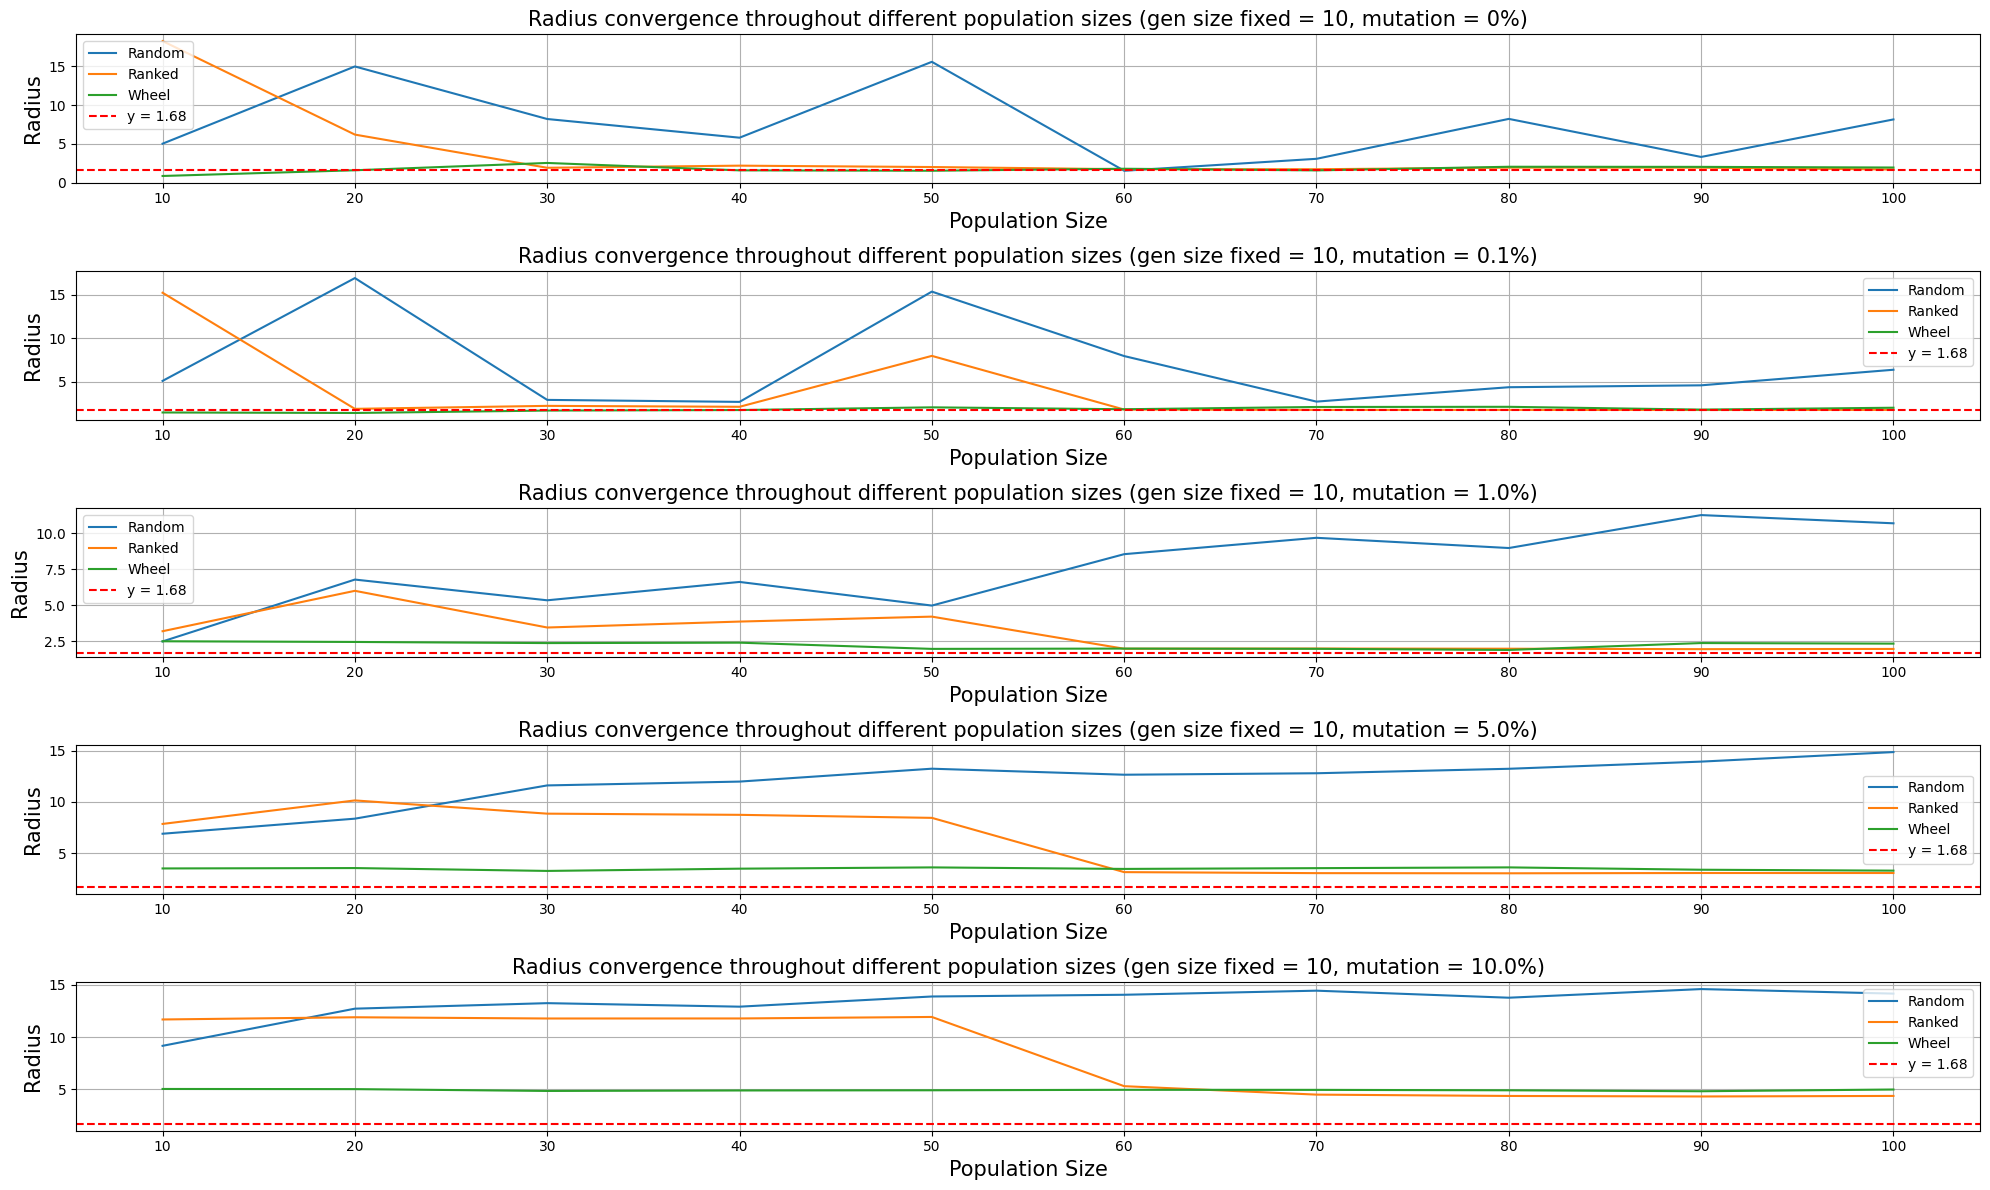

In [49]:
#Visualising the impact of pop_size on results
mutation_rates = [0, 0.001, 0.01, 0.05, 0.1]

# Define a function to create subplots for a given mutation rate
def pop_subplot(mutation_rate, subplot_index):
    mutation_df = generations_df[generations_df['mutation'] == mutation_rate]
    grouped_pop = mutation_df.groupby(by=['selection_type', 'pop_size']).mean()
    gen_size = len(grouped_pop.loc['Random Selection', 'radius'])
    x1 = range(gen_size)
    y1 = grouped_pop.loc['Random Selection', 'radius']
    y2 = grouped_pop.loc['Ranked Selection', 'radius']
    y3 = grouped_pop.loc['Wheel Selection', 'radius']

    plt.subplot(5, 1, subplot_index)
    plt.title(f'Radius convergence throughout different population sizes (gen size fixed = {gen_size}, mutation = {mutation_rate * 100}%)', fontsize=15)
    plt.xlabel('Population Size', fontsize=15)
    plt.ylabel('Radius', fontsize=15)

    plt.plot(x1, y1, label='Random')
    plt.plot(x1, y2, label='Ranked')
    plt.plot(x1, y3, label='Wheel')

    plt.grid()
    plt.axhline(y=1.6841, color='r', linestyle='--', label='y = 1.68')
    plt.legend()

    plt.xticks(range(len(grouped_pop.loc['Random Selection', 'radius'])), labels=grouped_pop.loc['Random Selection', 'radius'].index)


# Create subplots using a for loop
plt.rcParams["figure.figsize"] = (20, 12)
i=1
for mutation_rate in mutation_rates:
    pop_subplot(mutation_rate, i)
    i+=1

plt.tight_layout()
plt.show()


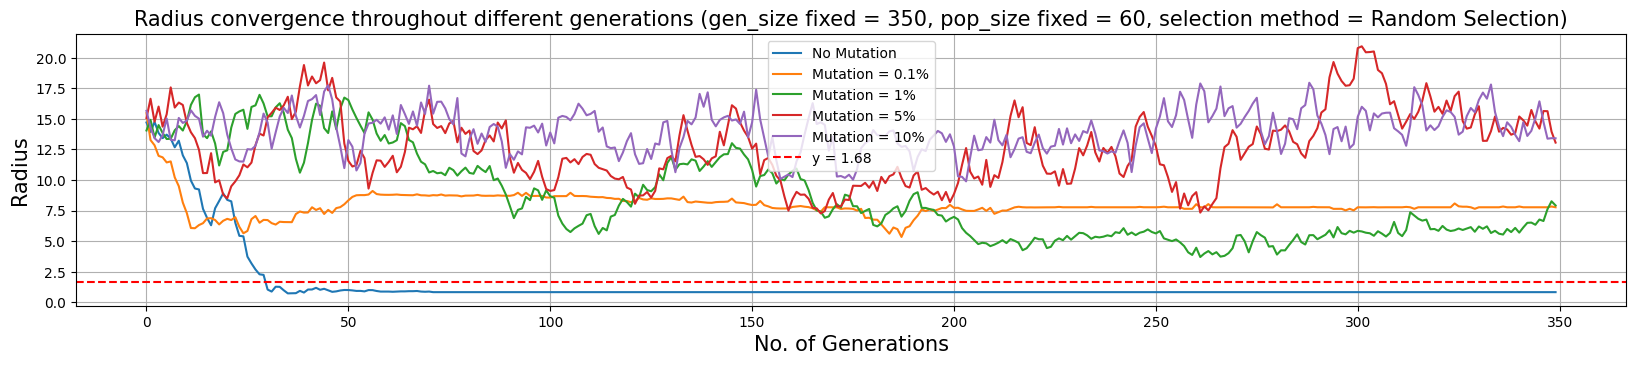

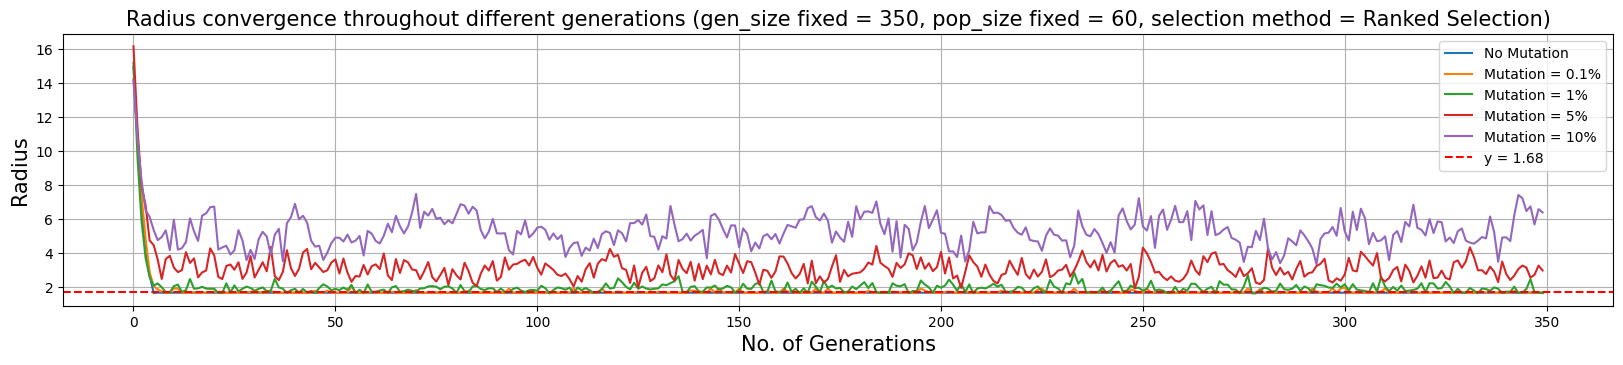

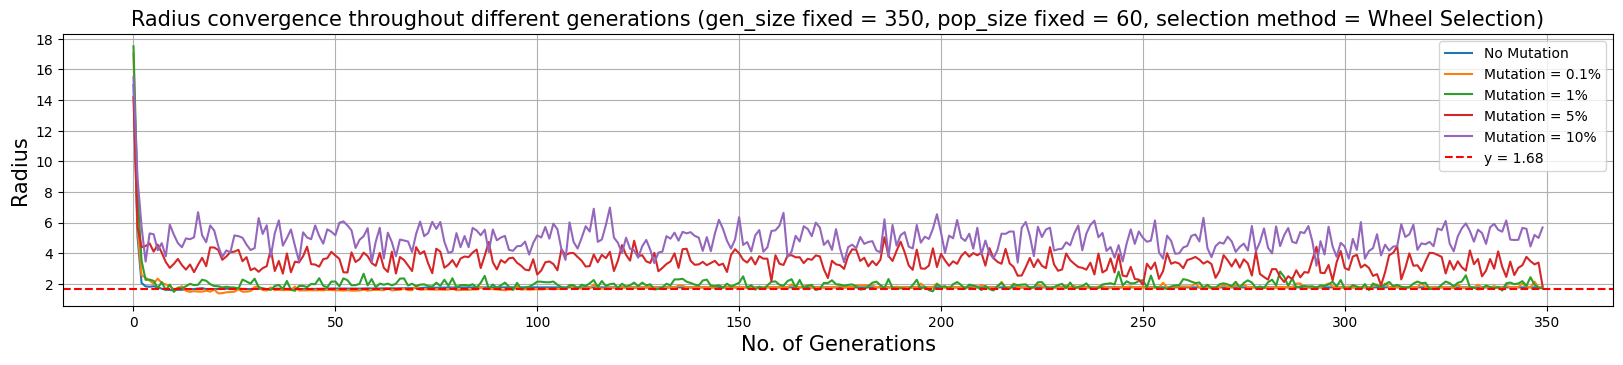

<Figure size 2000x1200 with 0 Axes>

In [52]:
#Visualising the results of different mutation rates on the population
#1. Filtering data by optimal population size
ideal_pop_size = 60
mutation_generations_df= generations_df[generations_df['pop_size']== ideal_pop_size]
selection_methods=['Random Selection','Ranked Selection','Wheel Selection']

# Define a function to create subplots for a given selection method
def sel_subplot(selection, subplot_index):
    mutation_generations_method_df= mutation_generations_df[mutation_generations_df['selection_type']==selection]
    grouped_pop = mutation_generations_method_df.groupby(by=['mutation','generation','selection_type']).mean()
    #indices = np.array(list(grouped_pop['radius'].index)).transpose()
    #cutoff_point = list(indices[0]).index(0.001) #find the generation size for the plot
    cutoff_point=350

    x1 = range(cutoff_point)
    y1 = (grouped_pop['radius'].values)[:cutoff_point]
    y2 = (grouped_pop['radius'].values)[cutoff_point:2*cutoff_point]
    y3 = (grouped_pop['radius'].values)[2*cutoff_point:3*cutoff_point]
    y4 = (grouped_pop['radius'].values)[3*cutoff_point:4*cutoff_point]
    y5 = (grouped_pop['radius'].values)[4*cutoff_point:]

    plt.subplot(3,1, subplot_index)
    plt.title(f'Radius convergence throughout different generations (gen_size fixed = {cutoff_point}, pop_size fixed = {ideal_pop_size}, selection method = {selection})',fontsize=15)
    plt.xlabel('No. of Generations',fontsize=15)
    plt.ylabel('Radius',fontsize=15)

    plt.plot(x1,y1, label = 'No Mutation') 
    plt.plot(x1,y2,label = 'Mutation = 0.1%')
    plt.plot(x1,y3,label = 'Mutation = 1%') 
    plt.plot(x1,y4, label = 'Mutation = 5%')  
    plt.plot(x1,y5, label = 'Mutation = 10%')


    plt.grid()

    plt.axhline(y=1.6841, color='r', linestyle='--', label='y = 1.68')
    #plt.xticks(range(len(grouped_pop.loc['Random Selection', 'radius'])), labels=grouped_pop.loc['Random Selection', 'radius'].index)
    plt.legend()

    plt.show()
    plt.close()
    

# Create subplots using a for loop
plt.rcParams["figure.figsize"] = (20, 12)
i=1
for selection in selection_methods:
    sel_subplot(selection, i)
    i+=1

plt.tight_layout()
plt.show()

In [36]:
#creating one DataFrame for each selection method
generations_df = pd.DataFrame(all_generations)
new_generations_df=generations_df[generations_df['mutation']==0]
#checking the results
new_generations_df.sample(5)

,radius,generation,fitness,selection_type,pop_size,mutation
249761,1.647059,79,0.018701,Ranked Selection,60,0.0
51281,15.529412,325,0.000658,Random Selection,50,0.0
565086,1.882353,225,0.018471,Wheel Selection,100,0.0
412015,1.529412,150,0.018543,Wheel Selection,40,0.0
40535,15.529412,110,0.000658,Random Selection,50,0.0


In [37]:
#Sample Statistics
new_generations_df.groupby(by=['selection_type', 'generation']).describe(percentiles = [0.5])


radius                                            \
                             count       mean       std       min        50%   
selection_type   generation                                                    
Random Selection 0           550.0  15.017112  8.796342  0.117647  14.823529   
                 1           550.0  14.509091  8.460482  0.117647  14.470588   
                 2           550.0  14.033583  8.342031  0.117647  14.294118   
                 3           550.0  13.495401  7.962668  0.235294  12.235294   
                 4           550.0  12.825882  7.671301  0.235294  11.882353   
...                            ...        ...       ...       ...        ...   
Wheel Selection  345         550.0   1.773262  0.283905  0.823529   1.882353   
                 346         550.0   1.773262  0.283905  0.823529   1.882353   
                 347         550.0   1.773262  0.283905  0.823529   1.882353   
                 348         550.0   1.773262  0.283905  0.823529   1.882353   
                 349         550.0   1.773262  0.283905  0.823529   1.882353   

                                       fitness                                \
                                   max   count      mean       std       min   
selection_type   generation                                                    
Random Selection 0           30.000000   550.0  0.002923  0.004754  0.000177   
                 1           30.000000   550.0  0.002949  0.004619  0.000177   
                 2           30.000000   550.0  0.003099  0.004754  0.000177   
                 3           29.882353   550.0  0.003075  0.004548  0.000178   
                 4           30.000000   550.0  0.003309  0.004796  0.000177   
...                                ...     ...       ...       ...       ...   
Wheel Selection  345          2.470588   550.0  0.018198  0.000922  0.012967   
                 346          2.470588   550.0  0.018198  0.000922  0.012967   
                 347          2.470588   550.0  0.018198  0.000922  0.012967   
                 348          2.470588   550.0  0.018198  0.000922  0.012967   
                 349          2.470588   550.0  0.018198  0.000922  0.012967   

                             ...   pop_size                    mutation       \
                             ...        std   min   50%    max    count mean   
selection_type   generation  ...                                               
Random Selection 0           ...  24.517196  10.0  70.0  100.0    550.0  0.0   
                 1           ...  24.517196  10.0  70.0  100.0    550.0  0.0   
                 2           ...  24.517196  10.0  70.0  100.0    550.0  0.0   
                 3           ...  24.517196  10.0  70.0  100.0    550.0  0.0   
                 4           ...  24.517196  10.0  70.0  100.0    550.0  0.0   
...                          ...        ...   ...   ...    ...      ...  ...   
Wheel Selection  345         ...  24.517196  10.0  70.0  100.0    550.0  0.0   
                 346         ...  24.517196  10.0  70.0  100.0    550.0  0.0   
                 347         ...  24.517196  10.0  70.0  100.0    550.0  0.0   
                 348         ...  24.517196  10.0  70.0  100.0    550.0  0.0   
                 349         ...  24.517196  10.0  70.0  100.0    550.0  0.0   

                                                 
                             std  min  50%  max  
selection_type   generation                      
Random Selection 0           0.0  0.0  0.0  0.0  
                 1           0.0  0.0  0.0  0.0  
                 2           0.0  0.0  0.0  0.0  
                 3           0.0  0.0  0.0  0.0  
                 4           0.0  0.0  0.0  0.0  
...                          ...  ...  ...  ...  
Wheel Selection  345         0.0  0.0  0.0  0.0  
                 346         0.0  0.0  0.0  0.0  
                 347         0.0  0.0  0.0  0.0  
                 348         0.0  0.0  0.0  0.0  
               

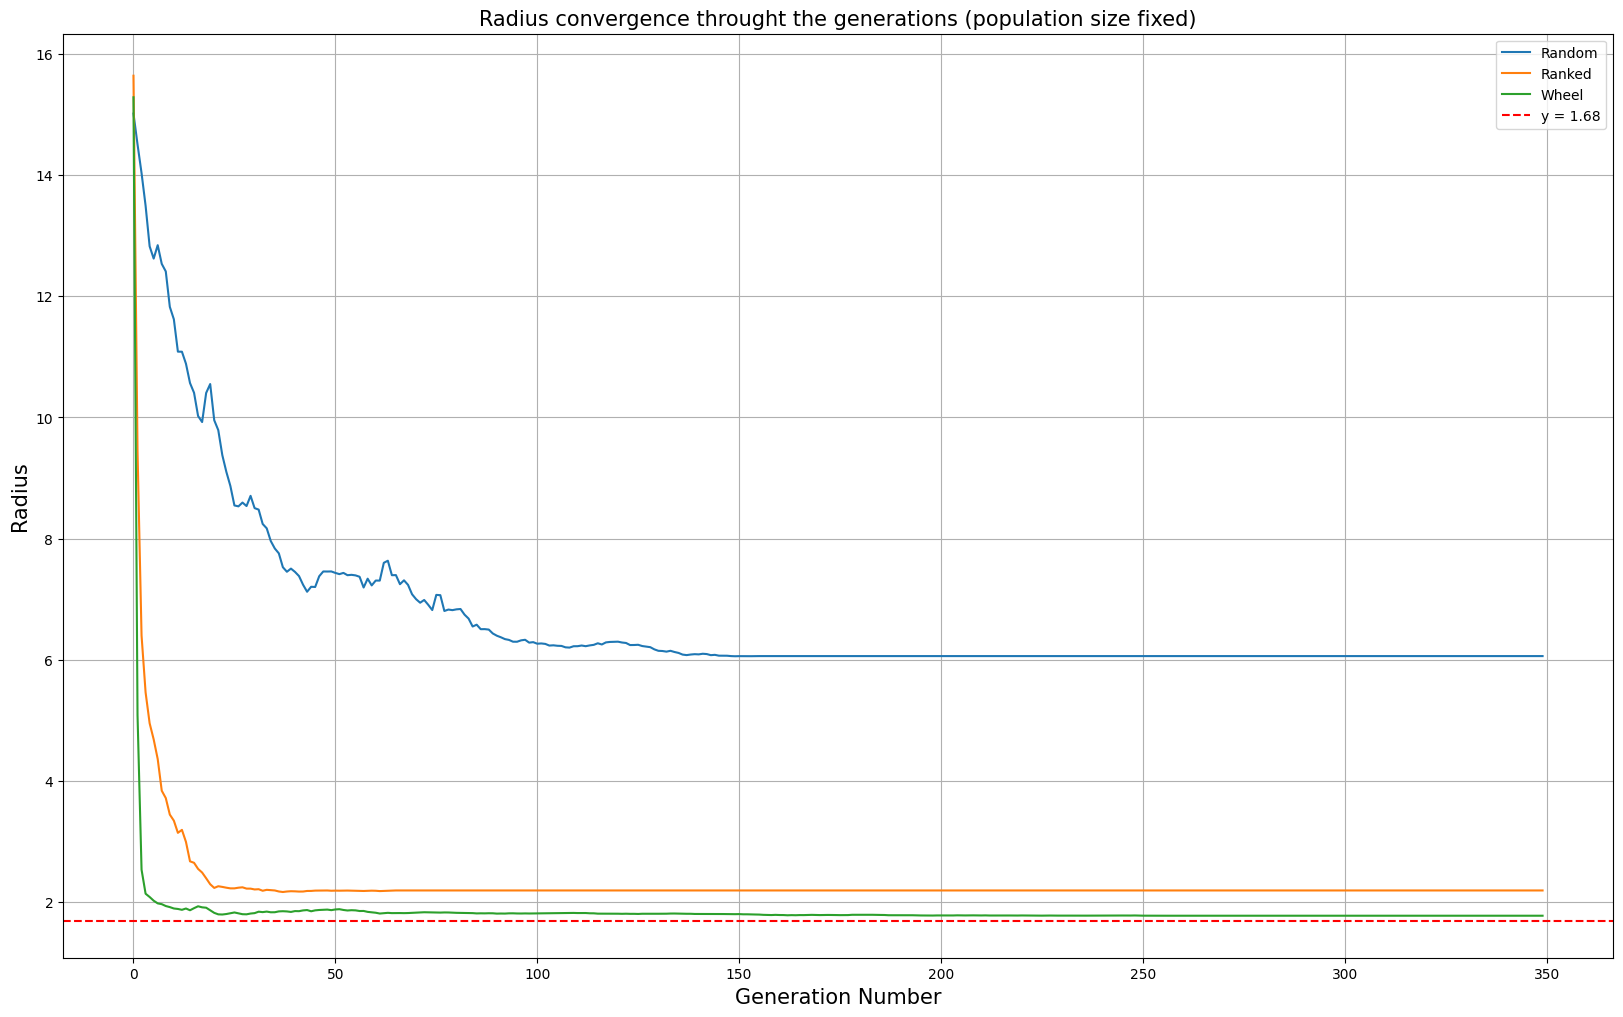

In [38]:
grouped = new_generations_df.groupby(by=['selection_type', 'generation']).mean()
#create plots

plt.rcParams["figure.figsize"]=(20,12)

x1 = range(len(grouped.loc['Random Selection', 'fitness']))
y1 = grouped.loc['Random Selection', 'radius']
y2 = grouped.loc['Ranked Selection', 'radius']
y3 = grouped.loc['Wheel Selection', 'radius']

plt.title('Radius convergence throught the generations (population size fixed)',fontsize=15)
plt.xlabel('Generation Number',fontsize=15)
plt.ylabel('Radius',fontsize=15)

plt.plot(x1,y1,label = 'Random')
plt.plot(x1,y2,label = 'Ranked') 
plt.plot(x1,y3, label = 'Wheel')  
plt.grid()
plt.axhline(y=1.6841, color='r', linestyle='--', label='y = 1.68')
plt.legend()

plt.show()

In [ ]:
grouped.loc['Random Selection', 'radius']

generation
0      15.017112
1      14.509091
2      14.033583
3      13.495401
4      12.825882
         ...    
345     6.059893
346     6.059893
347     6.059893
348     6.059893
349     6.059893
Name: radius, Length: 350, dtype: float64

In [ ]:
new_generations_df.groupby(by=['selection_type', 'pop_size']).describe(percentiles = [0.5])

radius                                            \
                             count       mean       std       min        50%   
selection_type   pop_size                                                      
Random Selection 10         3500.0   5.031025  1.016670  0.352941   4.941176   
                 20         7000.0  15.002571  1.127301  0.470588  15.058824   
                 30        10500.0   8.217401  1.453007  0.588235   8.000000   
                 40        14000.0   5.805588  2.587339  0.235294   5.411765   
                 50        17500.0  15.601876  1.866118  0.117647  15.529412   
                 60        21000.0   1.535266  3.135570  0.117647   0.823529   
                 70        24500.0   3.078079  4.975011  0.235294   1.294118   
                 80        28000.0   8.232034  2.036698  0.117647   7.764706   
                 90        31500.0   3.318058  2.989035  0.117647   2.352941   
                 100       35000.0   8.163872  2.118435  0.117647   7.764706   
Ranked Selection 10         3500.0  18.280303  0.671214  2.235294  18.235294   
                 20         7000.0   6.204084  1.598215  0.117647   6.235294   
                 30        10500.0   1.920482  2.343307  0.117647   1.529412   
                 40        14000.0   2.193782  2.666351  0.117647   1.764706   
                 50        17500.0   2.016087  2.420978  0.235294   1.647059   
                 60        21000.0   1.734583  1.165450  0.117647   1.647059   
                 70        24500.0   1.731592  1.204186  0.117647   1.647059   
                 80        28000.0   1.937542  0.948057  0.235294   1.882353   
                 90        31500.0   1.934626  0.917975  0.352941   1.882353   
                 100       35000.0   1.696921  0.904869  0.705882   1.647059   
Wheel Selection  10         3500.0   0.860840  0.935257  0.235294   0.823529   
                 20         7000.0   1.598739  1.006189  0.117647   1.529412   
                 30        10500.0   2.543406  0.953798  0.117647   2.470588   
                 40        14000.0   1.586790  0.901530  0.235294   1.529412   
                 50        17500.0   1.535160  1.123864  0.117647   1.411765   
                 60        21000.0   1.795395  0.925642  0.352941   1.764706   
                 70        24500.0   1.582295  0.974478  0.117647   1.529412   
                 80        28000.0   2.051710  0.895482  0.117647   2.000000   
                 90        31500.0   2.036665  1.033957  0.117647   1.882353   
                 100       35000.0   1.952427  0.850723  0.117647   1.882353   

                                     generation                          ...  \
                                 max      count   mean         std  min  ...   
selection_type   pop_size                                                ...   
Random Selection 10        28.470588     3500.0  174.5  101.050322  0.0  ...   
                 20        30.000000     7000.0  174.5  101.043102  0.0  ...   
                 30        29.882353    10500.0  174.5  101.040696  0.0  ...   
                 40        30.000000    14000.0  174.5  101.039493  0.0  ...   
                 50        29.764706    17500.0  174.5  101.038772  0.0  ...   
                 60        30.000000    21000.0  174.5  101.038290  0.0  ...   
                 70        30.000000    24500.0  174.5  101.037947  0.0  ...   
                 80        30.000000    28000.0  174.5  101.037689  0.0  ...   
                 90        30.000000    31500.0  174.5  101.037488  0.0  ...   
                 100       29.882353    35000.0  174.5  101.037328  0.0  ...   
Ranked Selection 10        28.352941     3500.0  174.5  101.050322  0.0  ...   
                 20        29.882353     7000.0  174.5  101.043102  0.0  ...   
                 30        30.000000    10500.0  174.5  101.040696  0.0  ...   
                 40        29.882353    14000.0  174.5  101.039493  0.0  ...   
                 50        

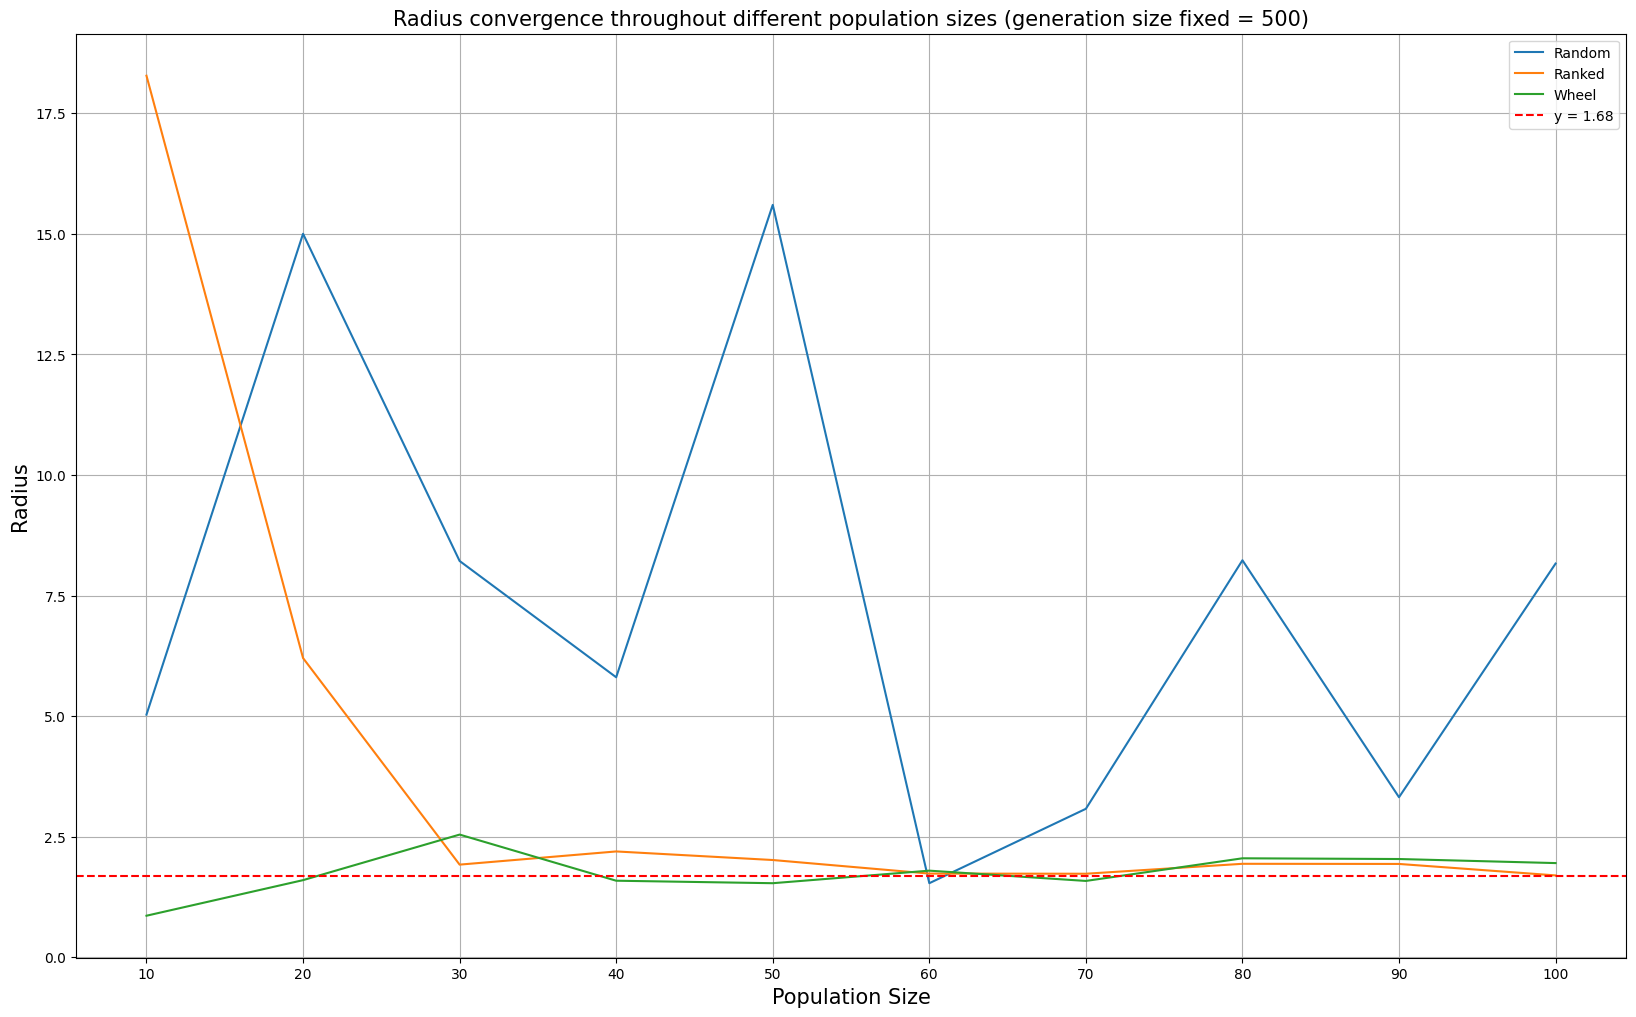

In [39]:
grouped_pop = new_generations_df.groupby(by=['selection_type', 'pop_size']).mean()
#create plots

plt.rcParams["figure.figsize"]=(20,12)

x1 = range(len(grouped_pop.loc['Random Selection', 'radius']))
y1 = grouped_pop.loc['Random Selection', 'radius']
y2 = grouped_pop.loc['Ranked Selection', 'radius']
y3 = grouped_pop.loc['Wheel Selection', 'radius']

plt.title('Radius convergence throughout different population sizes (generation size fixed = 500)',fontsize=15)
plt.xlabel('Population Size',fontsize=15)
plt.ylabel('Radius',fontsize=15)

plt.plot(x1,y1,label = 'Random')
plt.plot(x1,y2,label = 'Ranked') 
plt.plot(x1,y3, label = 'Wheel')  

plt.grid()
plt.axhline(y=1.6841, color='r', linestyle='--', label='y = 1.68')
plt.legend()

plt.xticks(range(len(grouped_pop.loc['Random Selection', 'radius'])), labels=grouped_pop.loc['Random Selection', 'radius'].index)
plt.show()

In [ ]:
grouped_pop.loc['Random Selection', 'radius'].values

array([ 5.03102521, 15.00257143,  8.21740056,  5.80558824, 15.60187563,
        1.53526611,  3.07807923,  8.23203361,  3.31805789,  8.16387227])

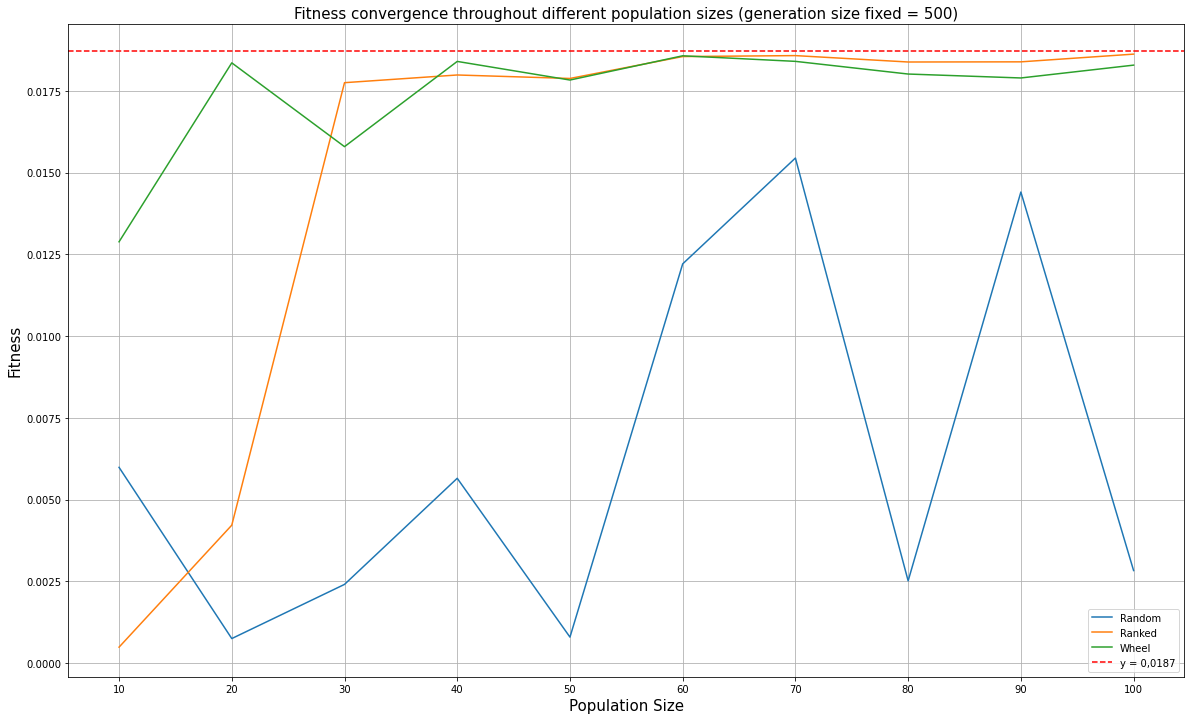

In [ ]:
grouped_pop = new_generations_df.groupby(by=['selection_type', 'pop_size']).mean()
#create plots

plt.rcParams["figure.figsize"]=(20,12)

x1 = range(len(grouped_pop.loc['Random Selection', 'fitness']))
y1 = grouped_pop.loc['Random Selection', 'fitness']
y2 = grouped_pop.loc['Ranked Selection', 'fitness']
y3 = grouped_pop.loc['Wheel Selection', 'fitness']

plt.title('Fitness convergence throughout different population sizes (generation size fixed = 500)',fontsize=15)
plt.xlabel('Population Size',fontsize=15)
plt.ylabel('Fitness',fontsize=15)

plt.plot(x1,y1,label = 'Random')
plt.plot(x1,y2,label = 'Ranked') 
plt.plot(x1,y3, label = 'Wheel')  
plt.grid()
plt.axhline(y=0.018709891942760622, color='r', linestyle='--', label='y = 0,0187')
plt.xticks(range(len(grouped_pop.loc['Random Selection', 'radius'])), labels=grouped_pop.loc['Random Selection', 'radius'].index)
plt.legend()

plt.show()

WITH MUTATIONS

In [ ]:
mutation_generations_df=generations_df[generations_df['mutation']!=0]
#checking the results
mutation_generations_df.sample(5)

,radius,generation,fitness,selection_type,pop_size,mutation
2832468,2.705882,127,0.014667,Wheel Selection,90,0.100
1008315,2.000000,216,0.018138,Wheel Selection,50,0.001
1220040,1.529412,209,0.018543,Random Selection,60,0.010
1037350,2.000000,19,0.018138,Wheel Selection,70,0.001
1214128,15.764706,110,0.000639,Random Selection,60,0.010


In [ ]:
#Sample Statistics
mutation_generations_df.groupby(by=['selection_type', 'generation']).describe(percentiles = [0.5])

radius                                            \
                              count       mean       std       min        50%   
selection_type   generation                                                     
Random Selection 0           2200.0  15.105294  8.670788  0.117647  15.294118   
                 1           2200.0  14.892193  8.652041  0.117647  15.058824   
                 2           2200.0  14.661444  8.467392  0.117647  14.470588   
                 3           2200.0  14.494759  8.488390  0.117647  14.588235   
                 4           2200.0  14.478128  8.472032  0.117647  14.529412   
...                             ...        ...       ...       ...        ...   
Wheel Selection  345         2200.0   3.203316  3.943944  0.117647   1.882353   
                 346         2200.0   3.196043  3.884567  0.117647   1.882353   
                 347         2200.0   3.068342  3.728538  0.117647   1.882353   
                 348         2200.0   2.951016  3.378096  0.117647   1.882353   
                 349         2200.0   3.047968  3.683078  0.117647   1.882353   

                                       fitness                                \
                                   max   count      mean       std       min   
selection_type   generation                                                    
Random Selection 0           30.000000  2200.0  0.002886  0.004754  0.000177   
                 1           30.000000  2200.0  0.002911  0.004726  0.000177   
                 2           29.882353  2200.0  0.002949  0.004733  0.000178   
                 3           30.000000  2200.0  0.003069  0.004864  0.000177   
                 4           30.000000  2200.0  0.003133  0.004989  0.000177   
...                                ...     ...       ...       ...       ...   
Wheel Selection  345         28.000000  2200.0  0.014893  0.005828  0.000203   
                 346         29.058824  2200.0  0.015029  0.005804  0.000188   
                 347         28.470588  2200.0  0.015140  0.005597  0.000196   
                 348         26.000000  2200.0  0.015148  0.005549  0.000235   
                 349         26.000000  2200.0  0.015070  0.005604  0.000235   

                             ...   pop_size                    mutation  \
                             ...        std   min   50%    max    count   
selection_type   generation  ...                                          
Random Selection 0           ...  24.500466  10.0  70.0  100.0   2200.0   
                 1           ...  24.500466  10.0  70.0  100.0   2200.0   
                 2           ...  24.500466  10.0  70.0  100.0   2200.0   
                 3           ...  24.500466  10.0  70.0  100.0   2200.0   
                 4           ...  24.500466  10.0  70.0  100.0   2200.0   
...                          ...        ...   ...   ...    ...      ...   
Wheel Selection  345         ...  24.500466  10.0  70.0  100.0   2200.0   
                 346         ...  24.500466  10.0  70.0  100.0   2200.0   
                 347         ...  24.500466  10.0  70.0  100.0   2200.0   
                 348         ...  24.500466  10.0  70.0  100.0   2200.0   
                 349         ...  24.500466  10.0  70.0  100.0   2200.0   

                                                                  
                                mean       std    min   50%  max  
selection_type   generation                                       
Random Selection 0           0.04025  0.039127  0.001  0.03  0.1  
                 1           0.04025  0.039127  0.001  0.03  0.1  
                 2           0.04025  0.039127  0.001  0.03  0.1  
                 3           0.04025  0.039127  0.001  0.03  0.1  
                 4           0.04025  0.039127  0.001  0.03  0.1  
...                              ...       ...    ...   ...  ...  
Wheel Selection  345         0.04025  0.039127  0.001  0.03  0.1  
                 346         0.04025  0.039127  0.00

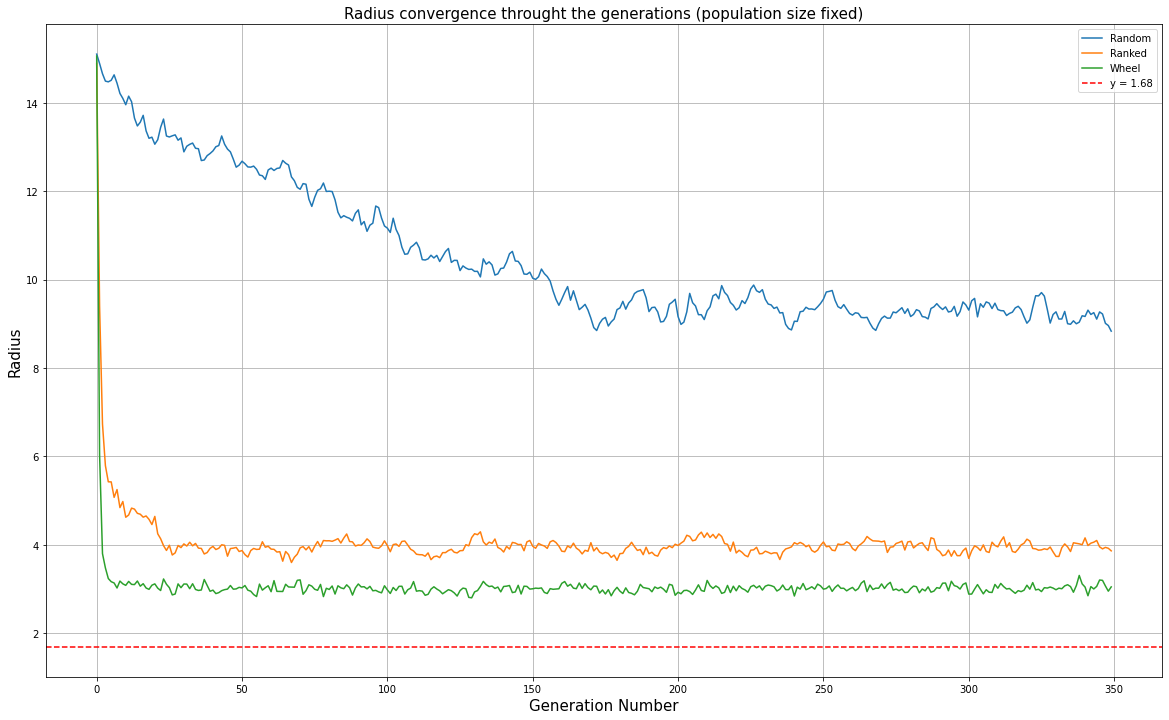

In [ ]:
grouped = mutation_generations_df.groupby(by=['selection_type', 'generation']).mean()
#create plots

plt.rcParams["figure.figsize"]=(20,12)

x1 = range(len(grouped.loc['Random Selection', 'fitness']))
y1 = grouped.loc['Random Selection', 'radius']
y2 = grouped.loc['Ranked Selection', 'radius']
y3 = grouped.loc['Wheel Selection', 'radius']

plt.title('Radius convergence throught the generations (population size fixed)',fontsize=15)
plt.xlabel('Generation Number',fontsize=15)
plt.ylabel('Radius',fontsize=15)

plt.plot(x1,y1,label = 'Random')
plt.plot(x1,y2,label = 'Ranked') 
plt.plot(x1,y3, label = 'Wheel')  
plt.grid()
plt.axhline(y=1.6841, color='r', linestyle='--', label='y = 1.68')
plt.legend()

plt.show()

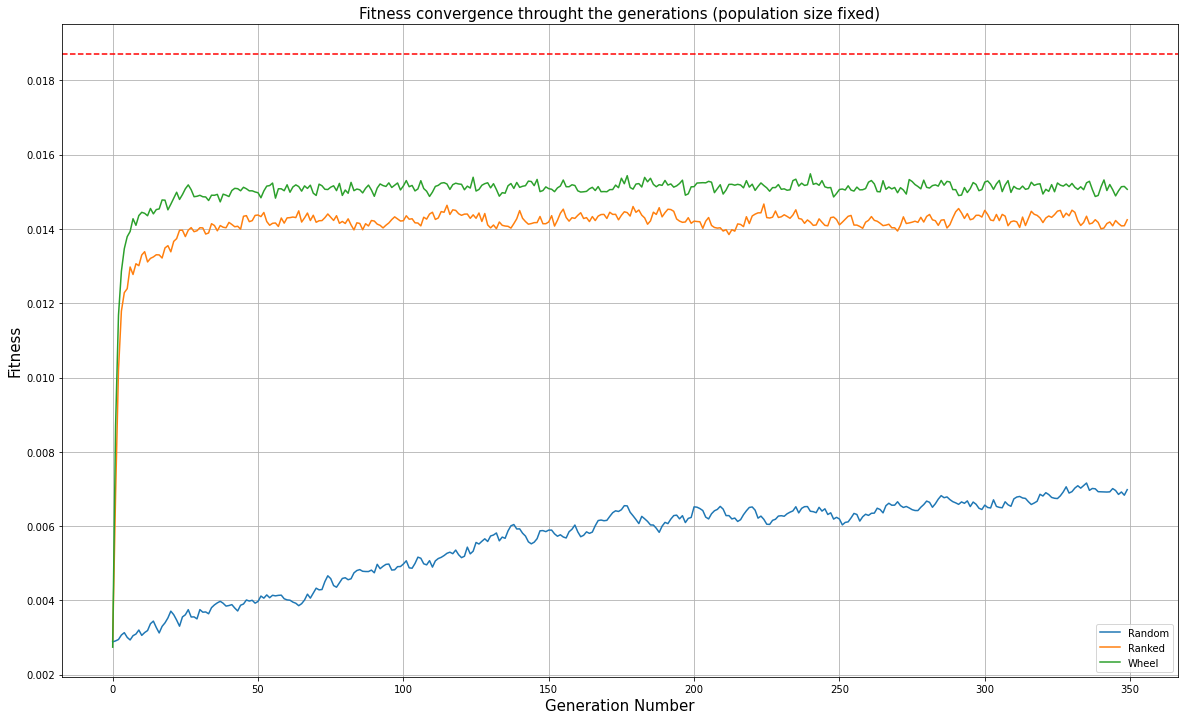

In [ ]:
grouped = mutation_generations_df.groupby(by=['selection_type', 'generation']).mean()
#create plots

plt.rcParams["figure.figsize"]=(20,12)

x1 = range(len(grouped.loc['Random Selection', 'fitness']))
y1 = grouped.loc['Random Selection', 'fitness']
y2 = grouped.loc['Ranked Selection', 'fitness']
y3 = grouped.loc['Wheel Selection', 'fitness']

plt.title('Fitness convergence throught the generations (population size fixed)',fontsize=15)
plt.xlabel('Generation Number',fontsize=15)
plt.ylabel('Fitness',fontsize=15)

plt.plot(x1,y1,label = 'Random')
plt.plot(x1,y2,label = 'Ranked') 
plt.plot(x1,y3, label = 'Wheel')  
plt.grid()
plt.legend()
plt.axhline(y=0.018709891942760622, color='r', linestyle='--', label='y = 0,0187')

plt.show()

In [ ]:
#mutation_generations_df=generations_df[generations_df['mutation']!=0]
mutation_generations_df=generations_df
#mutation_generations_df= mutation_generations_df[mutation_generations_df['selection_type']=='Ranked Selection']
mutation_generations_df= mutation_generations_df[mutation_generations_df['pop_size']== 60]
mutation_generations_df.head()

,radius,generation,fitness,selection_type,pop_size,mutation
52500,1.647059,0,0.018701,Random Selection,60,0.0
52501,1.529412,0,0.018543,Random Selection,60,0.0
52502,1.294118,0,0.017579,Random Selection,60,0.0
52503,1.176471,0,0.016751,Random Selection,60,0.0
52504,2.470588,0,0.015965,Random Selection,60,0.0


In [ ]:
grouped_pop = mutation_generations_df.groupby(by=['mutation','generation']).mean()
grouped_pop

radius   fitness  pop_size
mutation generation                               
0.0      0           14.869935  0.003305      60.0
         1            9.839216  0.007207      60.0
         2            7.858170  0.009511      60.0
         3            6.549673  0.010871      60.0
         4            5.969281  0.011732      60.0
...                        ...       ...       ...
0.1      345          7.471242  0.008932      60.0
         346          6.834641  0.008893      60.0
         347          6.787582  0.008767      60.0
         348          7.071242  0.008007      60.0
         349          7.593464  0.007993      60.0

[1750 rows x 3 columns]

In [ ]:
fuck_you = np.array(list(grouped_pop['radius'].index)).transpose()
fuck_you[0]

array([0. , 0. , 0. , ..., 0.1, 0.1, 0.1])

In [ ]:
list(fuck_you[0]).index(0.001)

350

In [ ]:
grouped_pop = mutation_generations_df.groupby(by=['selection_type', 'generation']).mean()
#create plots

plt.rcParams["figure.figsize"]=(20,12)

x1 = range(len(grouped_pop['mutation'] == 0.001))
y1 = grouped_pop[grouped_pop['mutation'] == 0.001].loc['Random Selection', 'radius']
y2 = grouped_pop[grouped_pop['mutation'] == 0.01].loc['Random Selection', 'radius']
y3 = grouped_pop[grouped_pop['mutation'] == 0.1].loc['Random Selection', 'radius']
y4 = grouped_pop[grouped_pop['mutation'] == 0.05].loc['Random Selection', 'radius']

plt.title('Radius convergence throughout different population sizes (generation size fixed = 500)',fontsize=15)
plt.xlabel('Population Size',fontsize=15)
plt.ylabel('Radius',fontsize=15)

plt.plot(x1,y1,label = '0.1%')
plt.plot(x1,y2,label = '1%') 
plt.plot(x1,y3, label = '10%') 
plt.plot(x1,y4, label = '5%')  

plt.grid()
plt.axhline(y=1.6841, color='r', linestyle='--', label='y = 1.68')
plt.legend()

plt.xticks(range(len(grouped_pop.loc['Random Selection', 'radius'])), labels=grouped_pop.loc['Random Selection', 'radius'].index)
plt.show()

KeyError: 'Random Selection'